In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from zipfile import ZipFile

with ZipFile('../content/drive/MyDrive/yoga.zip', 'r') as zip:
    zip.extractall()

In [12]:
train_path = "../content/images/train_images"
test_path = "../content/images/test_images"

WIDTH = 75
HEIGHT = 75
IMAGE_CHANNELS = 3
batch_size = 20



In [13]:
df = pd.read_csv('train.csv')
df['class_6'] = df['class_6'].astype(str)

In [52]:
df

,image_id,class_6
0,1daf45401342ac321c0aa5668f51d004.jpg,5
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4
2,1dc97053cf67cb8e51c983abb0021083.jpg,4
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0
...,...,...
2355,3cb75d7569544a8be6850893dc939ed6.jpg,4
2356,fa14b6703b1eda25b4a851c163a1efc2.jpg,5
2357,e58ee6afa09efc6021e8b56a9bda6960.jpg,0
2358,94c16216e9674ec1a254c73d56d2ebe1.jpg,2


In [55]:

df_train=df.sample(frac=0.8,replace=False)
df_valid=df.drop(df_train.index.values)



In [48]:
df_train

,image_id,class_6
989,25e622e189d2a3eaaeee3362c9b22b97.jpg,0
218,5632aa9667782209220a3a61d9e9392c.jpg,0
104,a395fbb19094a49c35a536406b863aab.jpg,0
2049,7630e6e019960a6da6cb0a08208c158a.jpg,4
2080,6389555ea70dd50d73162239f019d00e.jpg,3
...,...,...
352,7ff9f674b8bd926c5e087b04f1c8e918.jpg,0
2306,9c798a7b9d71ef6cfddb2087c5162dfb.jpg,4
1600,865f7eafcaf2658cee40ad76ac59e0f1.jpg,0
2317,53058b33cc87c030159d54edf4f83122.jpg,2


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization


model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, IMAGE_CHANNELS)),
        MaxPooling2D(pool_size=(3, 3)),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(64, (2, 2), activation='relu',padding='same'),

        MaxPooling2D(pool_size=(2, 2)),


        Conv2D(128, (2, 2), activation='relu',padding='same'),

        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),


        Flatten(),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')# 6 because we have 6 classes
])


model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 49, 49, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 23, 23, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 23, 23, 64)       

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                   rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )



In [64]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
earlystop = EarlyStopping(patience=6,restore_best_weights=True)

In [65]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    directory=train_path,
    x_col='image_id',
    y_col='class_6',
    target_size=(WIDTH, HEIGHT),
    class_mode='categorical',
    batch_size=batch_size,
)

validation_generator = validation_datagen.flow_from_dataframe(
    df_valid,
    directory=train_path,
    x_col='image_id',
    y_col='class_6',
    target_size=(WIDTH, HEIGHT),
    class_mode='categorical',
    batch_size=batch_size
)

Found 1888 validated image filenames belonging to 6 classes.
Found 472 validated image filenames belonging to 6 classes.


236.0

In [66]:
history = model.fit(
    train_generator,
    batch_size=batch_size,
    epochs=50,
    validation_data=validation_generator,

    validation_steps=472  //batch_size,
    steps_per_epoch= 1888 //batch_size,
    callbacks=[earlystop]
)

Epoch 1/50
94/94 [==============================] - 29s 272ms/step - loss: 0.1658 - accuracy: 0.1984 - val_loss: 0.1974 - val_accuracy: 0.2435
Epoch 2/50
94/94 [==============================] - 29s 310ms/step - loss: 0.1741 - accuracy: 0.2227 - val_loss: 0.1614 - val_accuracy: 0.2348
Epoch 3/50
94/94 [==============================] - 28s 301ms/step - loss: 0.1628 - accuracy: 0.2157 - val_loss: 0.1408 - val_accuracy: 0.2543
Epoch 4/50
94/94 [==============================] - 25s 272ms/step - loss: 0.1561 - accuracy: 0.2088 - val_loss: 0.1542 - val_accuracy: 0.2283
Epoch 5/50
94/94 [==============================] - 26s 272ms/step - loss: 0.1544 - accuracy: 0.2125 - val_loss: 0.1619 - val_accuracy: 0.1587
Epoch 6/50
94/94 [==============================] - 25s 267ms/step - loss: 0.1475 - accuracy: 0.2350 - val_loss: 0.1635 - val_accuracy: 0.1739
Epoch 7/50
94/94 [==============================] - 25s 269ms/step - loss: 0.1489 - accuracy: 0.2377 - val_loss: 0.1424 - val_accuracy: 0.1391

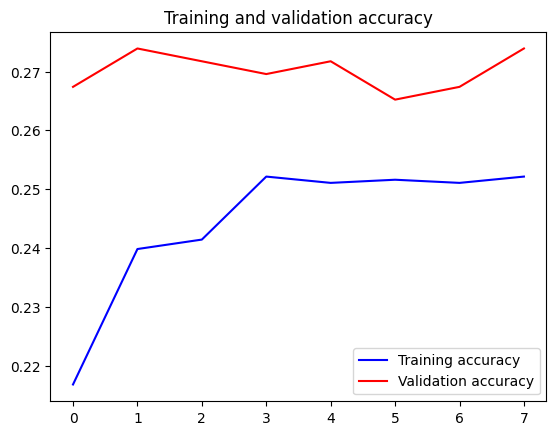

<Figure size 640x480 with 0 Axes>

In [37]:

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

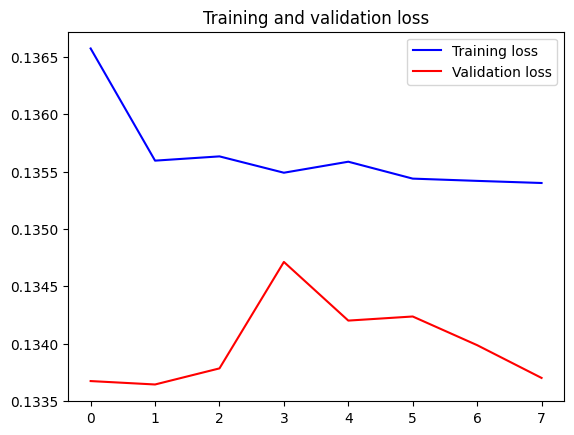

<Figure size 640x480 with 0 Axes>

In [38]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()